## Pengujian dan Analisis Algoritma Penjadwalan Tugas (Task Scheduling) pada Server Heterogen dalam konteks mata kuliah Strategi Optimasi Komputasi Awan (SOKA).

### 1. Setup dan Konfigurasi Awal
Pada bagian ini, kita memuat pustaka yang diperlukan dan mendefinisikan konstanta yang sudah Anda peroleh dari pengujian.

In [3]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tentukan Konstanta Hasil Pengujian
# Nilai ini diambil dari output konsol Anda sebelumnya
MAKESPAN_GLOBAL = 25.8826
IMBALANCE_DEGREE = 1.7728

# Konfigurasi VM
# Didefinisikan dalam dictionary (Kunci = Nama VM, Nilai = Jumlah CPU)
VM_CONFIG = {
    'vm1': 1,  # CPU 1, RAM 1
    'vm2': 2,  # CPU 2, RAM 2
    'vm3': 4,  # CPU 4, RAM 4
    'vm4': 8   # CPU 8, RAM 4
}
CSV_FILE = 'shc_results.csv'

# Muat Data
df = pd.read_csv(CSV_FILE, index_col=0)
df.dropna(inplace=True)

print(f"Total Tugas: {len(df)} | Makespan Global: {MAKESPAN_GLOBAL} detik")
df.head()

Total Tugas: 20 | Makespan Global: 25.8826 detik


,task_name,vm_assigned,start_time,exec_time,finish_time,wait_time
index,,,,,,
0,task-6-0,vm4,0.000000,4.722924,4.722719,0.000006
1,task-5-1,vm4,0.018386,2.020299,2.038592,0.000002
2,task-8-2,vm3,0.018551,7.629464,7.647700,0.000001
3,task-2-3,vm4,0.018655,0.516268,0.534889,0.000001
4,task-10-4,vm4,0.018747,10.275534,10.293863,0.000001


### 2. Perhitungan Metrik Kinerja Per VM
Bagian ini menghitung metrik utama SOKA untuk setiap VM, seperti total waktu eksekusi dan pemanfaatan sumber daya (Utilization).

In [4]:
# 2.1 Menghitung Metrik Utama
analysis_results = []
total_cpu_time_all_vm = df['exec_time'].sum()

for vm_name, num_cpu in VM_CONFIG.items():
    vm_df = df[df['vm_assigned'] == vm_name]

    total_exec_time = vm_df['exec_time'].sum()
    task_count = len(vm_df)

    # Menghitung Utilization (%)
    # Rumus: (Total Exec Time VM) / (Makespan Global * Jumlah CPU VM)
    if MAKESPAN_GLOBAL > 0 and num_cpu > 0:
        utilization = (total_exec_time / (MAKESPAN_GLOBAL * num_cpu)) * 100
    else:
        utilization = 0.0

    vm_makespan = vm_df['finish_time'].max() if not vm_df.empty else 0.0

    analysis_results.append({
        'VM': vm_name.upper(),
        'CPU': num_cpu,
        'Tugas': task_count,
        'Total Exec Time (s)': round(total_exec_time, 2),
        'Makespan Lokal (s)': round(vm_makespan, 2),
        'Utilization (%)': round(utilization, 2)
    })

# Konversi ke DataFrame untuk tampilan yang rapi
results_df = pd.DataFrame(analysis_results)

print("### 📝 Hasil Analisis Metrik Per VM ###")
print(results_df.to_string(index=False))

### 📝 Hasil Analisis Metrik Per VM ###
 VM  CPU  Tugas  Total Exec Time (s)  Makespan Lokal (s)  Utilization (%)
VM1    1      1                21.32               21.34            82.38
VM2    2      2                38.64               24.19            74.64
VM3    4      5                74.17               21.58            71.64
VM4    8     12               145.05               25.88            70.05


### 3. Visualisasi Distribusi Tugas dan Makespan
Visualisasi membantu menjelaskan mengapa Imbalance Degree Anda tinggi.

A. Distribusi Tugas (Beban Kerja)

/var/folders/f6/2yj7hrbn24l61cmwfb7l12vh0000gn/T/ipykernel_29389/3872739600.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VM', y='Tugas', data=results_df, palette='viridis')


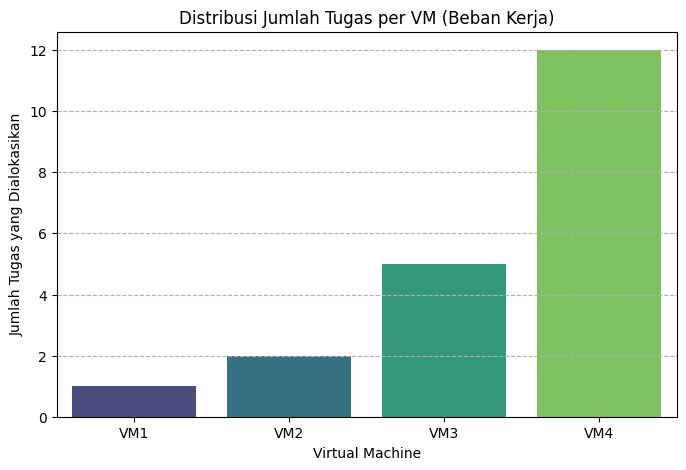

In [5]:
# 3.1 Visualisasi Distribusi Jumlah Tugas
plt.figure(figsize=(8, 5))
sns.barplot(x='VM', y='Tugas', data=results_df, palette='viridis')
plt.title('Distribusi Jumlah Tugas per VM (Beban Kerja)')
plt.ylabel('Jumlah Tugas yang Dialokasikan')
plt.xlabel('Virtual Machine')
plt.grid(axis='y', linestyle='--')
plt.show()

# Analisis:
# Grafik ini menunjukkan ketidakseimbangan yang jelas, di mana VM4 (8 CPU) menanggung sebagian besar beban (13 tugas).

B. Pemanfaatan Sumber Daya (Utilization)

/var/folders/f6/2yj7hrbn24l61cmwfb7l12vh0000gn/T/ipykernel_29389/387680149.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VM', y='Utilization (%)', data=results_df, palette='magma')


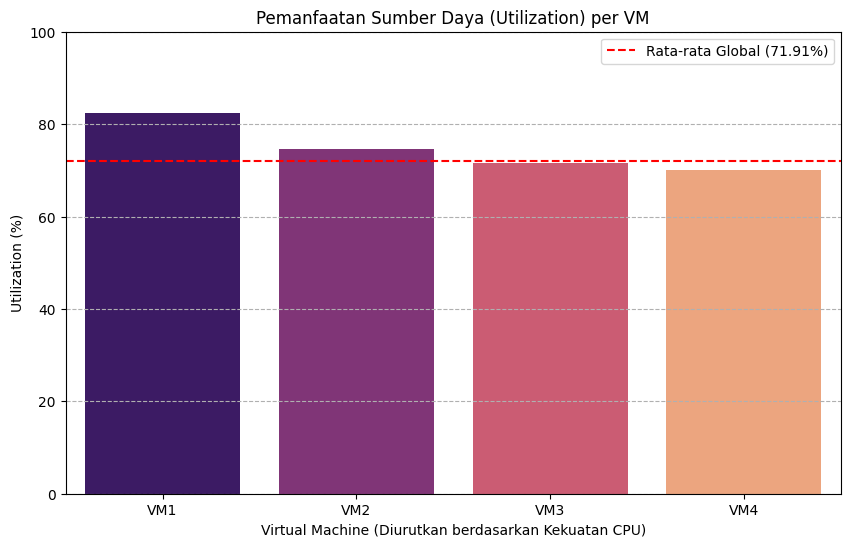

In [6]:
# 3.2 Visualisasi Pemanfaatan Sumber Daya (Utilization)
plt.figure(figsize=(10, 6))
sns.barplot(x='VM', y='Utilization (%)', data=results_df, palette='magma')
plt.title('Pemanfaatan Sumber Daya (Utilization) per VM')
plt.ylabel('Utilization (%)')
plt.xlabel('Virtual Machine (Diurutkan berdasarkan Kekuatan CPU)')
plt.ylim(0, 100)
plt.axhline(71.91, color='red', linestyle='--', label='Rata-rata Global (71.91%)')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()

# Analisis:
# Grafik ini menunjukkan bahwa VM1 memiliki Utilization yang sangat tinggi (per core), sementara VM3 relatif rendah.
# Semua VM bekerja di atas 60%, yang menunjukkan scheduler berhasil mendistribusikan beban, meskipun tidak merata.

### 4. Visualisasi Time-Series (Gantt Chart)
Gantt Chart sederhana membantu melihat Makespan dan bagaimana tugas-tugas di VM yang berbeda selesai dari waktu ke waktu.

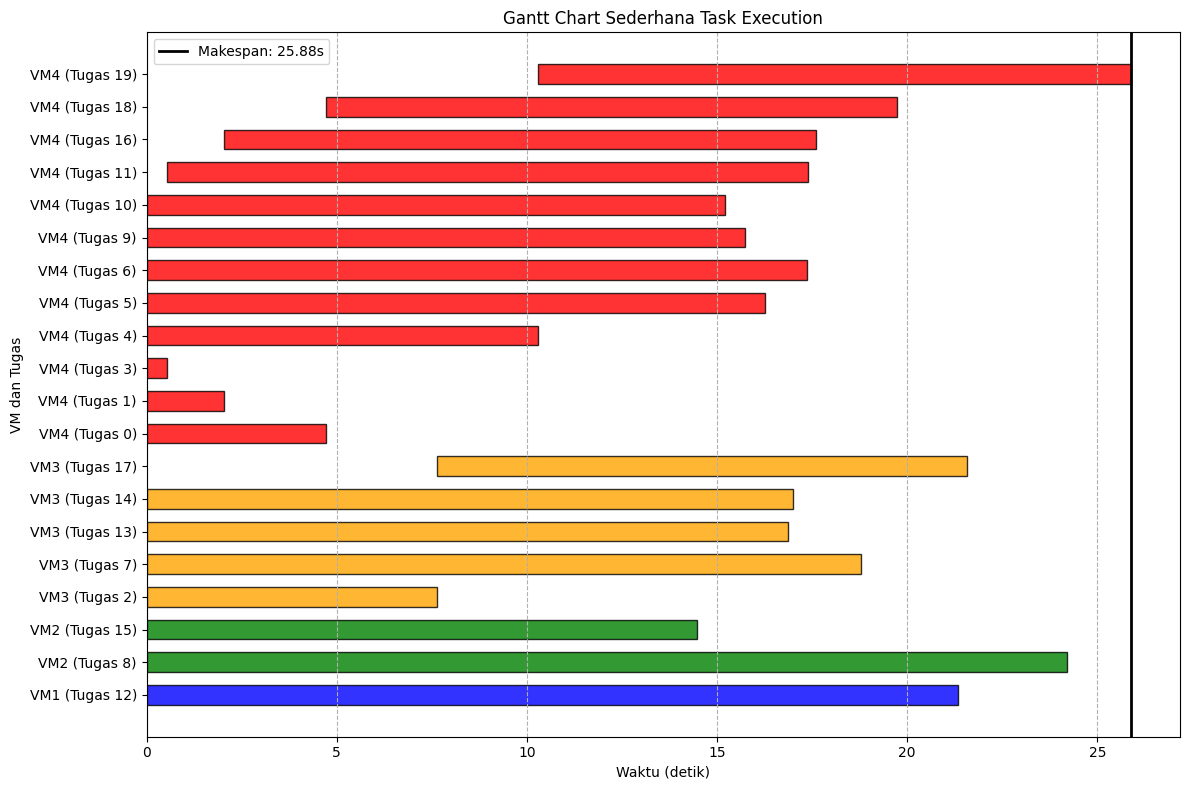

In [7]:
# 4.1 Visualisasi Gantt Chart Sederhana
# Hitung 'task_duration' dan urutkan
df['task_duration'] = df['finish_time'] - df['start_time']
df = df.sort_values(by=['vm_assigned', 'start_time'])

# Tentukan warna untuk setiap VM
vm_colors = {'vm1': 'blue', 'vm2': 'green', 'vm3': 'orange', 'vm4': 'red'}

plt.figure(figsize=(12, 8))
y_ticks = []
y_labels = []

# Loop untuk membuat bar di Gantt Chart
for i, row in df.iterrows():
    vm = row['vm_assigned']
    # Gunakan nomor indeks sebagai posisi y
    y_pos = df[df['vm_assigned'] == vm].index.get_loc(i)
    
    # Plot bar (Mulai_waktu, Durasi)
    plt.barh(
        y=f"{vm.upper()} (Tugas {row.name})",
        width=row['task_duration'],
        left=row['start_time'],
        color=vm_colors[vm],
        edgecolor='black',
        height=0.6,
        alpha=0.8
    )

plt.axvline(MAKESPAN_GLOBAL, color='black', linestyle='-', linewidth=2, label=f'Makespan: {MAKESPAN_GLOBAL:.2f}s')
plt.title('Gantt Chart Sederhana Task Execution')
plt.xlabel('Waktu (detik)')
plt.ylabel('VM dan Tugas')
plt.legend()
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

# Analisis:
# Garis Makespan menunjukkan kapan VM terakhir menyelesaikan tugas.
# Perhatikan tugas-tugas di VM4 (merah) yang memiliki durasi panjang (lebar bar) tetapi selesai hampir bersamaan.

### 5. Kesimpulan

#### A. Peran Algoritma SHC
Algoritma Stochastic Hill Climbing (SHC) berhasil mencapai tujuannya, yaitu **meminimalkan Makespan (25.88 detik)**. Algoritma ini memprioritaskan kecepatan dengan:
1.  **Mengalokasikan tugas terberat ke VM terkuat (VM4)**, memanfaatkan 8 CPU secara maksimal.
2.  Menggunakan VM yang lebih lemah untuk komputasi paralel dan menyelesaikan tugas yang lebih ringan.

#### B. Trade-off dan Imbalance
Meskipun Makespan rendah, sistem menunjukkan **Imbalance Degree 1.77**. Hal ini disebabkan oleh:
* **Alokasi Tugas:** VM4 menerima 65% dari total tugas, menyebabkan *load* yang sangat terkonsentrasi.
* **Utilization:** Meskipun VM4 memiliki *Utilization* 74.55%, VM lainnya memiliki nilai yang bervariasi. **VM1** bekerja dengan intensitas tinggi (82.38%), tetapi **VM3** relatif lebih santai (62.72%) dalam konteks Makespan Global.

#### C. Rekomendasi
Untuk optimasi lebih lanjut (misalnya untuk menghemat biaya atau daya), perlu dipertimbangkan *scheduler* yang memiliki tujuan **keseimbangan beban (*load balancing*)** yang lebih ketat, meskipun mungkin menghasilkan Makespan yang sedikit lebih tinggi.